# Iterative $\alpha$-(De)Blending

In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import make_circles, make_moons, make_swiss_roll
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
try:
    from google.colab import drive
except:
    ROOT = '.'
else:
    drive.mount('/content/drive')
    ROOT = '/content/drive/My Drive/Informatique/Notebooks'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

___

## 2D

### Generating Data.

In [3]:
def sample_x0(size, scale=1):
    x = scale * np.random.randn(size, 2)
    return x
x0 = sample_x0(1000)

In [4]:
def sample_x1(size, noise=0.1, factor=0.1):
    x, _ = make_moons(n_samples=size, noise=noise)
    x[:,0] = x[:,0] - 0.5
    x[:,1] = 2*x[:,1] - 0.5
    return x
x1 = sample_x1(1000)

### Visualizing Data.

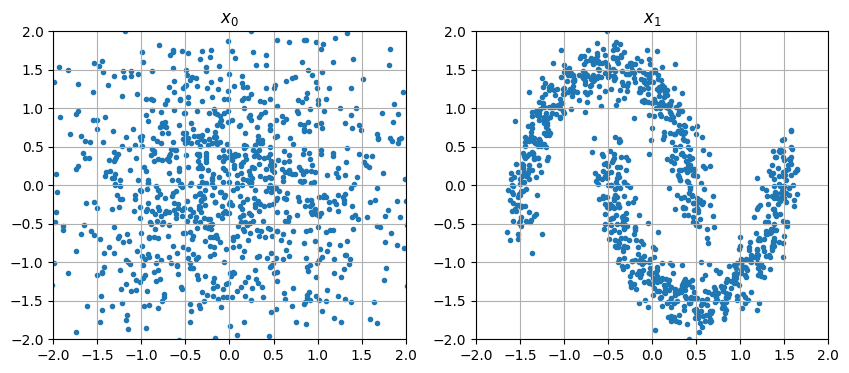

In [5]:
fig, axs = plt.subplots(1,2,figsize=(10,4))

axs[0].scatter(x0[:,0], x0[:,1], marker='.')
axs[0].grid()
axs[0].set_title('$x_0$')
axs[0].set_xlim([-2, 2]); axs[0].set_ylim([-2, 2]);

axs[1].scatter(x1[:,0], x1[:,1], marker='.')
axs[1].grid()
axs[1].set_title('$x_1$')
axs[1].set_xlim([-2, 2]); axs[1].set_ylim([-2, 2]);

plt.show()

In [6]:
SIZE = 10000
dataset_x0 = torch.Tensor(sample_x0(SIZE))
dataset_x1 = torch.Tensor(sample_x1(SIZE))
print(f"{dataset_x0.shape = }")
print(f"{dataset_x1.shape = }")

dataset_x0.shape = torch.Size([10000, 2])
dataset_x1.shape = torch.Size([10000, 2])


### Neural Network Architecture.

#### Positional Encoding.

In [7]:
class PositionalEncoding(nn.Module):

    def __init__(self, encoding_dim, max_len=1000):
        super().__init__()
        # Encoding frequencies
        k = torch.arange(0, encoding_dim, 2)
        wk = torch.exp(- math.log(10000) / encoding_dim * k)
        self.wk = wk
        # Self parameters
        self.max_len = max_len
        self.enc_dim = encoding_dim

    def forward(self, a):
        # a.shape: [batch_size, len_a]
        pos_enc = torch.zeros(a.size(0), a.size(1), self.enc_dim)
        # pos_enc.shape: [batch_size, len_a, encoding_dim]        
        pos_enc[:, 0, 0::2] = torch.sin(a * self.wk)
        pos_enc[:, 0, 1::2] = torch.cos(a * self.wk)
        return pos_enc

#### Multi-Layer Perceptron.

In [10]:
# Architecture
class MLP(nn.Module):
    def __init__(self, pos_enc_dim=8, device='cpu'):
        super().__init__()
        self.pos_enc = PositionalEncoding(encoding_dim=pos_enc_dim)
        self.linear1 = torch.nn.Linear(2 + pos_enc_dim,64) # input = (x_alpha, pos_enc(alpha))
        self.linear2 = torch.nn.Linear(64 + pos_enc_dim, 64)
        self.linear3 = torch.nn.Linear(64 + pos_enc_dim, 64)
        self.linear4 = torch.nn.Linear(64 + pos_enc_dim, 64)
        self.output  = torch.nn.Linear(64 + pos_enc_dim, 2)  # output = (x_1 - x_0)
        self.silu = torch.nn.SiLU()
        self.device = device

    def forward(self, x, a):
        # Positional encoding
        enc = self.pos_enc(a)
        enc = enc.squeeze(dim=1)
        # Linear layers
        res = x.clone()
        res = self.silu(self.linear1(torch.cat([res, enc], dim=1)))
        res = self.silu(self.linear2(torch.cat([res, enc], dim=1)))
        res = self.silu(self.linear3(torch.cat([res, enc], dim=1)))
        res = self.silu(self.linear4(torch.cat([res, enc], dim=1)))
        res = self.output(torch.cat([res, enc], dim=1))
        return res

In [11]:
model = MLP(pos_enc_dim=8, device=DEVICE).to(DEVICE)

In [12]:
y = model(x=torch.randn(64, 2).to(DEVICE), a=torch.rand(64, 1).to(DEVICE))
print(y.shape)

torch.Size([64, 2])


In [13]:
PATH = ROOT + '/models/diffusion.pt'
#model.load_state_dict(torch.load(PATH))

### Training Loop.

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss(reduction='mean')

In [15]:
BATCH_SIZE = 256
NUM_EPOCHS = 1000

In [16]:
for epoch in tqdm(range(NUM_EPOCHS)):

    # Shuffle datasets
    permutation = torch.randperm(SIZE)
    permutation_x0 = dataset_x0[permutation].to(DEVICE)
    permutation_x1 = dataset_x1[permutation].to(DEVICE)

    # Parse datasets
    for batch_i in range(0, SIZE-BATCH_SIZE, BATCH_SIZE):

        batch_x0 = permutation_x0[batch_i : batch_i+BATCH_SIZE]
        batch_x1 = permutation_x1[batch_i : batch_i+BATCH_SIZE]
        batch_alpha = torch.rand(BATCH_SIZE, 1, device=DEVICE)
        batch_xa = (1 - batch_alpha) * batch_x0 + batch_alpha * batch_x1

        output = model(batch_xa, batch_alpha)
        target = batch_x1 - batch_x0
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


  0%|          | 0/1000 [00:00<?, ?it/s]

In [17]:
torch.save(model.state_dict(), PATH)

### Sampling Loop.

  0%|          | 0/101 [00:00<?, ?it/s]

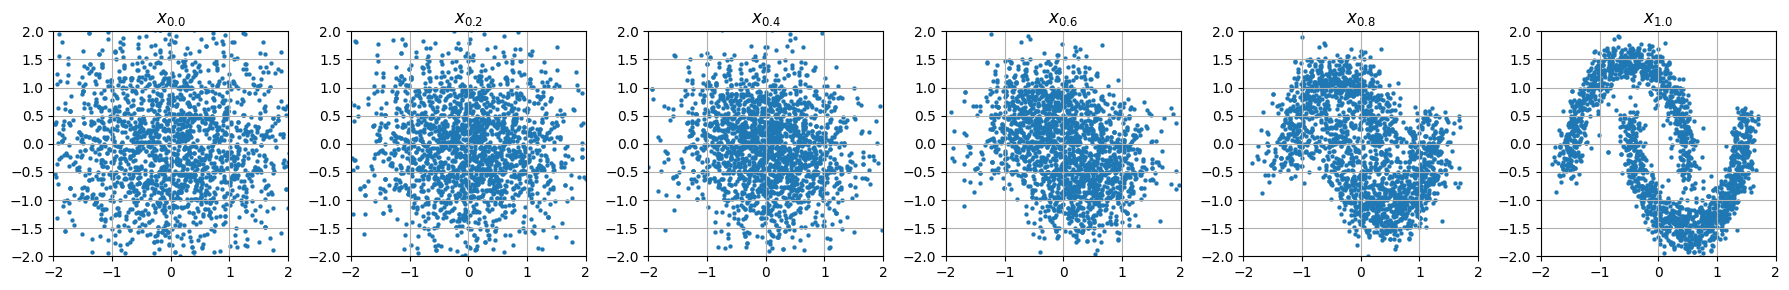

In [18]:
with torch.no_grad():

    NUM_PLOTS = 5
    fig, axs = plt.subplots(1, NUM_PLOTS+1, figsize=(18,3))

    # Starting point x_a = x_0
    BATCH_SIZE = 2048
    batch_x0 = dataset_x0[np.random.randint(0, SIZE, BATCH_SIZE)].to(DEVICE)
    batch_xa = batch_x0.clone()

    # Loop
    T = 100
    for t in tqdm(range(T+1)):

        # Current alpha value
        alpha = t/T
        batch_a = alpha * torch.ones(BATCH_SIZE, 1, device=DEVICE)
        # Update
        batch_xa = batch_xa + (1/T) * model(batch_xa, batch_a)

        # Visualize
        if (t % (T//NUM_PLOTS) == 0):
            i = t//(T//NUM_PLOTS)
            axs[i].scatter(batch_xa.cpu().data.numpy()[:,0], batch_xa.cpu().data.numpy()[:,1], marker='.', linewidth=0.1)
            axs[i].set_title(f"$x_{{{alpha}}}$")
            axs[i].set_xlim([-2, 2]);
            axs[i].set_ylim([-2, 2]);
            axs[i].grid(True)

    fig.tight_layout()
    plt.show()